In [107]:
import numpy as np
import random
import itertools
from operator import attrgetter
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

import PIL
from jinja2 import Environment
from IPython.display import HTML, display, Math
import os

In [108]:
def display(cards):
    card_files = [[]]
    for card in cards:
        name = card.name
        suit = card.suit.lower()
        if card.value < 11:
            name = card_name_map[name]
        card_files[0].append(os.path.join('Cards.3', '{}_of_{}.png'.format(name, suit)))
                                  
    jinja_template = """
        <table style="border:0px solid black;">
        {% for row in array %}
            <tr style="border:0px solid black;">
            {% for col in row %}
                <td style="background-color:white;
                            border-collapse:collapse;
                            text-align:center;
                            border:0px solid black;">
                    <img border="10" src="{{ col }}" alt="N/A" width="100px">
                </td>
            {% endfor %}
            </tr>
        {% endfor %}
         </table>"""
    HTML_content = Environment().from_string(jinja_template).render(array=card_files)
    return HTML(HTML_content)

In [109]:
def display_rows(rows):
    card_files = []
    for i, row in enumerate(rows):
        card_files.append([])
        for card in row.cards:
            name = card.name
            suit = card.suit.lower()
            if card.value < 11:
                name = card_name_map[name]
            card_files[i].append(os.path.join('Cards.3', '{}_of_{}.png'.format(name, suit)))
                                  
    jinja_template = """
        <table style="border:0px solid black;">
        {% for row in array %}
            <tr style="border:0px solid black;">
            {% for col in row %}
                <td style="background-color:white;
                            border-collapse:collapse;
                            text-align:center;
                            border:0px solid black;">
                    <img border="10" src="{{ col }}" alt="N/A" width="100px">
                </td>
            {% endfor %}
            </tr>
        {% endfor %}
         </table>"""
    HTML_content = Environment().from_string(jinja_template).render(array=card_files)
    return HTML(HTML_content)

In [110]:
suits = {'Hearts', 'Clubs', 'Spades', 'Diamonds'}

card_name_map = {
            'Two': 2,
            'Three': 3,
            'Four': 4,
            'Five': 5,
            'Six': 6,
            'Seven': 7,
            'Eight': 8,
            'Nine': 9,
            'Ten': 10,
            'Jack': 11, 
            'Queen': 12, 
            'King': 13, 
            'Ace': 14
            }

class Card:
    def __init__(self, name, suit):
        self.suit = suit
        self.name = name
        if self.name == 'Six':
            self.name_plural = 'Sixes'
        else:
            self.name_plural = self.name + 's'
        self.value = card_name_map[self.name]
        if self.value < 10:
            self.abbreviation = str(self.value)
        elif self.value == 10:
            self.abbreviation = 'T'
        else:
            self.abbreviation = self.name[0]
    
    def __str__(self):
        return '{} of {}'.format(self.name, self.suit)
    
    def __eq__(self, other):
        return self.value == other.value

In [111]:
class Deck:
    def __init__(self):
        self.deck = []
        self.card_location_map = {}
        for suit in suits:
            for card_name in card_name_map:
                self.deck.append(Card(card_name, suit))
        self.shuffle()
                
    def __str__(self):
        return ''.join(['{} \n'.format(card) for card in self.deck])
    
    def assign_locations(self):
        self.card_location_map = {}
        for i, card in enumerate(self.deck):
            self.card_location_map[str(card)] = i
        
    
    def shuffle(self):
        random.shuffle(self.deck)
        self.assign_locations()
    
    def remove(self, card):
        card = self.deck.pop(self.card_location_map[str(card)])
        self.assign_locations()
        return card
        
    
    def draw(self):
        card = self.deck.pop(0)
        self.assign_locations()
        return card
    
    def __str__(self):
        return ''.join(['{} \n'.format(card) for card in self.deck])

In [154]:
df = pd.read_csv('pre_flop_rank.csv')
pre_flop_hand_ranks = {'{}{}'.format(i[1], i[2]): i[0] for i in zip(list(df["Rank"]), list(df['Cards']), list(df['Type']))}


class PreFlopHand:
    def __init__(self, cards):
        self.cards = cards
        self.max_card = max(cards, key=attrgetter('value'))
        self.min_card = min(cards, key=attrgetter('value'))
        self.suited = self.max_card.suit == self.min_card.suit
        self.connected = self.max_card.value - self.min_card.value == 1 or self.max_card.value == 14 and self.min_card.value == 2
        self.pocket_pair = self.max_card == self.min_card
        if self.suited:
            self.hand_type = 's'
        else:
            self.hand_type = 'o'
        if self.pocket_pair:
            self.hand_type = 'p'
        self.abbreviation = "{}{}{}".format(self.max_card.abbreviation, self.min_card.abbreviation, self.hand_type)
        self.rank = pre_flop_hand_ranks[self.abbreviation]

In [121]:
class Hand:
    def __init__(self, cards):
        self.cards = cards
        self.max_card = max(self.cards, key=attrgetter('value'))
        self.card_suit_map = defaultdict(int)
        self.card_count_map = defaultdict(int)
        self.name = ''
        self.score = 0
        
        for card in self.cards:
            self.card_suit_map[card.suit] += 1
            self.card_count_map[card.value] += 1
    
    def is_royal(self):
        return 14 in self.card_count_map and 13 in self.card_count_map and 12 in self.card_count_map and 11 in self.card_count_map and 10 in self.card_count_map
    
    def is_flush(self):
        return len(self.card_suit_map) == 1
    
    def is_straight(self):
        self.cards.sort(key=lambda card_: card_.value)
        straight_flag = True
        for i in range(1, len(self.cards)):
            if self.cards[i].value - 1 != self.cards[i - 1].value:
                straight_flag = False
        
        if 14 in self.card_count_map and 2 in self.card_count_map and 3 in self.card_count_map and 4 in self.card_count_map and 5 in self.card_count_map:
            straight_flag = True
        
        return straight_flag
    
    def is_quads(self):
        for card in self.card_count_map:
            if self.card_count_map[card] == 4:
                return True
        return False
    
    def is_trips(self):
        for card in self.card_count_map:
            if self.card_count_map[card] == 3:
                return True
        return False
    
    def is_two_pair(self):
        pair_count = 0
        for card in self.card_count_map:
            if self.card_count_map[card] == 2:
                pair_count += 1
        return pair_count == 2
    
    def is_pair(self):
        for card in self.card_count_map:
            if self.card_count_map[card] == 2:
                return True
        return False
        
    def evaluate(self):
        royal = self.is_royal()
        flush = self.is_flush()
        straight = self.is_straight()
        quads = self.is_quads()
        trips = self.is_trips()
        two_pair = self.is_two_pair()
        pair = self.is_pair()
        
        if royal and flush:
            self.name = "Royal Flush"
            self.score = 10
            return
        
        if straight and flush:
            self.name = "Straight Flush"
            self.score = 9
            return
        
        if quads:
            self.name = "Quads"
            self.score = 8
            return
        
        if trips and pair:
            self.name = "Full House"
            self.score = 7
            return
        
        if flush:
            self.name = "Flush"
            self.score = 6
            return
        
        if straight:
            self.name = "Straight"
            self.score = 5
            return
        
        if trips:
            self.name = "Trips"
            self.score = 4
            return
        
        if two_pair:
            self.name = "Two Pair"
            self.score = 3
            return
        
        if pair:
            self.name = "Pair"
            self.score = 2
            return
            
        self.name = "High Card"
        self.score = 1        
    
    def __str__(self):
        cards = ''.join(['{} \n'.format(card) for card in self.cards])
        return '{}\n\n{}'.format(self.name, cards)

        
    def display(self):
        return display(self.cards)
        

In [122]:
class Player:
    def __init__(self, name):
        self.name = name   
        self.pre_flop_hand = None
        self.cards = []
        self.hand = None
        self.possible_hands = []
        self.best_hand = None
        self.stack = 0
        
    def __str__(self):
        return '{}{}'.format('Player: {}\n'.format(self.name), ''.join(['{} \n'.format(card) for card in self.cards]))
                                                                                               

In [123]:
class Table:
    def __init__(self, deck):
        self.deck = deck
        self.board_cards = []
        self.burned_cards = []
        self.pot = 0
    
    def display(self):
        return display(self.board_cards)

In [124]:
class Game:
    def __init__(self, players):
        self.players = [Player('{}'.format(i)) for i in range(players)]
        self.deck = Deck()
        self.table = Table(self.deck)
    
    def deal(self):
        for i in range(2):
            for player in self.players:
                player.cards.append(self.deck.draw())
                player.pre_flop_hand = PreFlopHand(player.cards)
    
    def burn(self):
        self.table.burned_cards.append(self.deck.draw())
        
    def draw(self):
        self.table.board_cards.append(self.deck.draw())
                
    def flop(self):
        self.burn()
        for i in range(3):
            self.draw()
    
    def turn(self):
        self.burn()
        self.draw()
    
    def river(self):
        self.burn()
        self.draw()
        
    def get_possible_hands(self, player):
        cards = player.cards + self.table.board_cards
        hands = []
        for comb in itertools.combinations(cards, 5):
            hand = Hand(list(comb))
            hand.evaluate()
            hands.append(hand)
        player.possible_hands = sorted(hands, key=lambda x: x.score)[::-1]
        return player.possible_hands
        
    def get_best_hand(self, player):
        player.best_hand = player.possible_hands[0]
        return player.best_hand
        
    def get_winning_hand(self):
        for player in g.players:
            self.get_possible_hands(player)
            self.get_best_hand(player)
            
        return max(g.players, key=lambda player: player.best_hand.score)

    
    def __str__(self):
        return ''.join(['{}\n'.format(player) for player in self.players])
    
    def display_players(self):
        return display_rows(self.players)
    
    def display_best_hands(self):
        return display_rows([player.best_hand for player in self.players])
    

In [160]:
g = Game(3)
g.deal()

for player in g.players:
    print(player.pre_flop_hand.rank)
    
g.display_players()

151
24
117


,
,
,


In [146]:
g.flop()
g.turn()
g.river()
g.table.display()

,,,,


In [37]:
winner = g.get_winning_hand()

print(winner.name)

print(winner.best_hand)

winner.best_hand.display()

5
Straight

Ten of Spades 
Jack of Hearts 
Queen of Diamonds 
King of Spades 
Ace of Spades 



,,,,


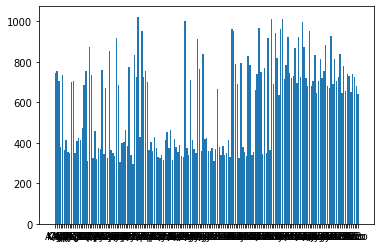

In [158]:
winning_pre_flop_hand_count = {'{}{}'.format(i[0], i[1]): 0 for i in zip(list(df['Cards']), list(df['Type']))}

for i in range(100000):
    g = Game(9)
    g.deal()
    g.flop()
    g.turn()
    g.river()
    winning_pre_flop_hand_count[g.get_winning_hand().pre_flop_hand.abbreviation] += 1
    
winning_pre_flop_hand_count

plt.bar(*zip(*winning_pre_flop_hand_count.items()))
plt.show()

In [159]:
winning_pre_flop_hand_count

{'AAp': 744,
 'KKp': 756,
 'QQp': 703,
 'AKs': 377,
 'JJp': 733,
 'AQs': 367,
 'KQs': 414,
 'AJs': 357,
 'KJs': 349,
 'TTp': 699,
 'AKo': 703,
 'ATs': 350,
 'QJs': 409,
 'KTs': 422,
 'QTs': 413,
 'JTs': 471,
 '99p': 684,
 'AQo': 756,
 'A9s': 310,
 'KQo': 875,
 '88p': 735,
 'K9s': 325,
 'T9s': 458,
 'A8s': 321,
 'Q9s': 374,
 'J9s': 368,
 'AJo': 762,
 'A5s': 344,
 '77p': 671,
 'A7s': 326,
 'KJo': 853,
 'A4s': 366,
 'A3s': 351,
 'A6s': 333,
 'QJo': 919,
 '66p': 687,
 'K8s': 305,
 'T8s': 397,
 'A2s': 406,
 '98s': 461,
 'J8s': 386,
 'ATo': 773,
 'Q8s': 340,
 'K7s': 296,
 'KTo': 836,
 '55p': 724,
 'JTo': 1023,
 '87s': 428,
 'QTo': 953,
 '44p': 726,
 '33p': 757,
 '22p': 700,
 'K6s': 363,
 '97s': 406,
 'K5s': 360,
 '76s': 427,
 'T7s': 376,
 'K4s': 331,
 'K3s': 327,
 'K2s': 341,
 'Q7s': 316,
 '86s': 416,
 '65s': 454,
 'J7s': 374,
 '54s': 461,
 'Q6s': 315,
 '75s': 417,
 '96s': 378,
 'Q5s': 356,
 '64s': 391,
 'Q4s': 333,
 'Q3s': 328,
 'T9o': 1000,
 'T6s': 372,
 'Q2s': 338,
 'A9o': 710,
 '53s': 41

In [173]:
s = "iiii"

import string

"".join([str(string.ascii_lowercase.index(char) + 1) for char in s])

# ''.join([string.ascii_lowercase.index(char) for char in s])

'9999'